In [70]:
#libraries
library(pracma)
library(ggplot2)
library(maps) 
#user functions
source('R_lib/regression/inla/regression_inla_model1_unbounded_hyp.R')

In [71]:
#regression name
reg_name  <- 'SD_regression_ds1_inla'

#regression dataset
  #fit inla model
  #---   ---   ---   ---   ---   ---
  if(runinla_flag){
    #run model (spatial)
    if(flag_gp_approx == TRUE){
      fit_inla_spatial <- inla(form_inla_spatial, 
                               data = inla.stack.data(stk_inla_spatial),
                               family="gaussian",
                               control.family = list(hyper = list(prec = prior_phi_0)),
                               control.fixed = prior_fixed,
                               control.predictor = list(A = inla.stack.A(stk_inla_spatial)),
                               control.compute = list(dic = TRUE, cpo = TRUE, waic = TRUE),
                               control.inla = list(int.strategy='eb', strategy="gaussian"),
                               verbose=TRUE,  num.threads=n_threads)
    }else{
      fit_inla_spatial <- inla(form_inla_spatial, 
                               data = inla.stack.data(stk_inla_spatial),
                               family="gaussian",
                               control.family = list(hyper = list(prec = prior_phi_0)),
                               control.fixed = prior_fixed,
                               control.predictor = list(A = inla.stack.A(stk_inla_spatial)),
                               control.compute = list(dic = TRUE, cpo = TRUE, waic = TRUE),
                               verbose=TRUE,  num.threads=n_threads)
    }
    #save results
    dir.create(out_dir, showWarnings=FALSE, recursive=TRUE)
    save(fit_inla_spatial, file=file.path(out_dir,paste0(out_fname,'_inla_fit','.Rdata')) )
  }else{
    #load results
    load(file.path(out_dir,paste0(out_fname,'_inla_fit','.Rdata')) )
  }

#output directory
dir_out <- 'data/SD_ds1_inla/'

#INLA regression parameters
runinla_flag <- TRUE # TRUE or FALSE
res_name     <- 'PGA'
#res_name <- 'tot'
#mesh coarseness
# #fine
# mesh_edge_max     <- 5
# mesh_inner_offset <- 15
# mesh_outer_offset <- 15
# #medium
# mesh_edge_max     <- 15
# mesh_inner_offset <- 15
# mesh_outer_offset <- 50
#coarse
mesh_edge_max     <- 40
mesh_inner_offset <- 40
mesh_outer_offset <- 45

#approximation options
# if flag_gp_approx=TRUE uses int.strategy="eb" and strategy="gaussian"
# int.strategy="eb" corresponds to one integration point, and 
# strategy="gaussian" approximates posteriors as gaussian distributions
flag_gp_approx <- TRUE # TRUE or FALSE

#number of threads
# reduce number of threads if running out of memmory, if not specified
# number of CPU threads is used
n_threads <- 8

In [72]:
#load flatfile
utmzone = 10
df_flatfile <- read.csv(flatfile_fname)
names(df_flatfile) <- c('eqid','date','eqlat','eqlon','eqZ','mag','SD','SDD','Site','R','Vs30','Vs30class','PGA','stalat','stalon')
df_flatfile$ssn <- df_flatfile$Site
df_flatfile$UTMzone <- utmzone #north california

eq<-LongLatToUTM(df_flatfile$eqlat,df_flatfile$eqlon,utmzone)
df_flatfile[,c('eqX','eqY')] <- eq[,c('X','Y')]/1000

sta<-LongLatToUTM(df_flatfile$stalat,df_flatfile$stalon,utmzone)
df_flatfile[,c('staX','staY')] <- sta[,c('X','Y')]/1000

#df_flatfile

#df_flatfile <- read.csv('/home/yow004/Projects/nonergodicSD/data/CatalogNGAWest3CALite_synthetic_data_ngmm1_small_corr_len_Y1.csv')

In [73]:
#run INLA model
out_fname <- reg_name



# Preprocess Input Data
# ---------------------------
n_data <- nrow(df_flatfile)
#earthquake data
data_eq_all <- df_flatfile[,c('eqid','mag','eqX', 'eqY')]
out_unq  <- UniqueIdxInv(df_flatfile[,'eqid'])
eq_idx   <- out_unq$idx
eq_inv   <- out_unq$inv
data_eq  <- data_eq_all[eq_idx,]
X_eq     <- data_eq[,c(3,4)] #earthquake coordinates
X_eq_all <- data_eq_all[,c(3,4)]
#create earthquake ids for all records (1 to n_eq)
eq_id <- eq_inv
n_eq  <- nrow(data_eq)
  


In [74]:
#station data
data_sta_all <- df_flatfile[,c('ssn','Vs30','staX','staY')]
out_unq   <- UniqueIdxInv(df_flatfile[,'ssn'])
sta_idx   <- out_unq$idx
sta_inv   <- out_unq$inv
data_sta  <- data_sta_all[sta_idx,]
X_sta     <- data_sta[,c(3,4)] #station coordinates
X_sta_all <- data_sta_all[,c(3,4)]
#create station indices for all records (1 to n_sta)
sta_id <- sta_inv
n_sta  <- nrow(data_sta)

In [75]:
#ground-motion observations  
y_data <- df_flatfile[,res_name]

In [76]:
#UTM zone
utm_zone <- unique(df_flatfile$UTMzone)
utm_no   <- as.numeric(gsub("([0-9]+).*$", "\\1", utm_zone))

In [77]:
# Run INLA, fit model 
# ---------------------------
#fixed effects 
#---   ---   ---   ---   ---   ---
#prior on the fixed effects
prior_fixed <- list(mean.intercept = 0, prec.intercept = 5,
                    mean = (list(intcp=0.0, default=0)),
                    prec = (list(intcp=5.0, default=0.01)))

#covariates
df_inla_covar <- data.frame(intcp = 1, eq = eq_id, sta = sta_id)

In [78]:
#spatial model
#---   ---   ---   ---   ---   ---
#input arguments
edge_max     <- mesh_edge_max
inner_offset <- mesh_inner_offset
outer_offset <- mesh_outer_offset

#domain mesh
mesh <- inla.mesh.2d(loc=rbind(as.matrix(X_eq),as.matrix(X_sta)) ,
                    max.edge = c(1,5)*edge_max,
                    cutoff = 3, offset = c(inner_offset, outer_offset))

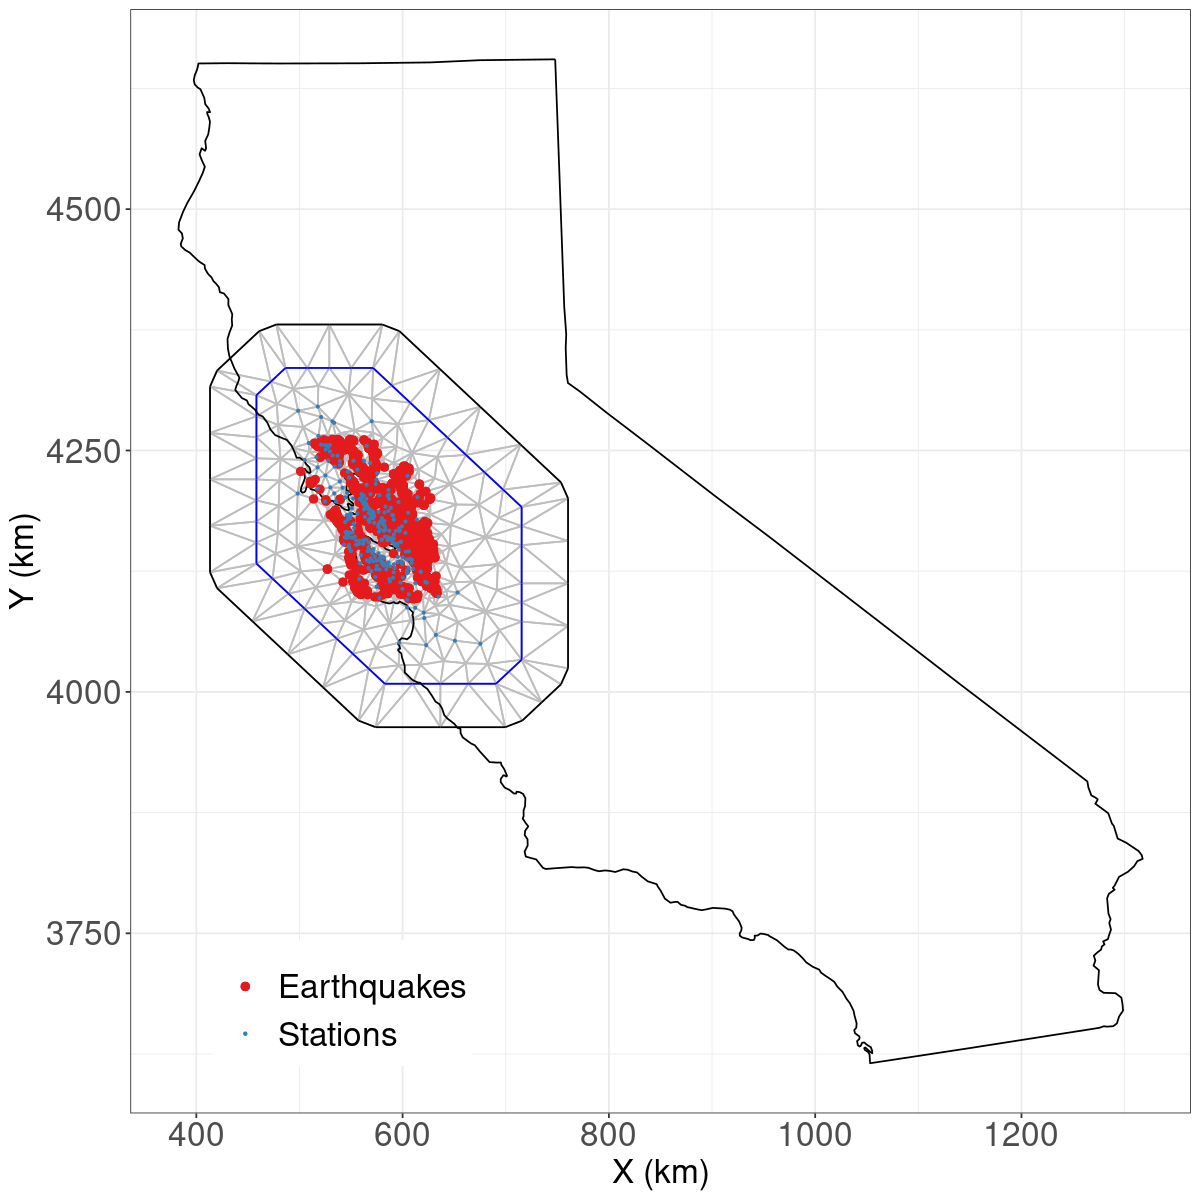

In [135]:
options(repr.plot.width=10, repr.plot.height=10)
# Plotting
# ---------------------------    
#plotting info
set1   <- RColorBrewer::brewer.pal(7, "Set1") #color map
#California
map_ca <- subset( map_data("state"), region %in% c("california"))
map_ca_utm <- LongLatToUTM(lat=map_ca$lat, lon=map_ca$long, utm_no)
map_ca[,c('X','Y')] <- map_ca_utm[,c('X','Y')]/1000
#Nevada
map_nv <- subset( map_data("state"), region %in% c("nevada"))
map_nv_utm <- LongLatToUTM(lat=map_nv$lat, lon=map_nv$long, utm_no)
map_nv[,c('X','Y')] <- map_nv_utm[,c('X','Y')]/1000


  #Earthquake - Station Mesh
  pl_mesh  <- ggplot() + theme_bw() + gg(mesh) +
              geom_path(data=map_ca, aes(x=X,y=Y), color='black') +
              geom_point(data=X_eq, aes(x=eqX,y=eqY, size=as.factor('EQ'), color=as.factor('EQ'))) +
              geom_point(data=X_sta, aes(x=staX,y=staY, size=as.factor('STA'), color=as.factor('STA'))) +
              scale_size_manual(values=c(2.0,0.5), labels = c('Earthquakes','Stations'), name=element_blank()) + 
              scale_color_manual(values=c(set1[1],set1[2]), labels = c('Earthquakes','Stations'), name=element_blank()) + 
              labs(x="X (km)", y="Y (km)") +
              theme(plot.title=element_text(size=20), axis.title=element_text(size=20), 
                    axis.text.y=element_text(size=20), axis.text.x=element_text(size=20),
                    legend.key.size = unit(1, 'cm'), legend.text=element_text(size=20), 
                    legend.position = c(0.20, 0.10))
print(pl_mesh)


In [140]:
alpha = 2
#prior distributions
  #site independent term
  prior_omega_1bs <- list(prec = list(prior = "loggamma", param = c(0.9, 0.007)))
  #spde earthquake prior
  spde_eq <- inla.spde2.pcmatern(mesh = mesh, alpha = alpha, # Mesh and smoothness parameter
                                 prior.range = c(100, 0.95), # P(range < 100) = 0.95
                                 prior.sigma = c(.30, 0.1))  # P(sigma > 0.30) = 0.10
  #spde station prior
  spde_sta <- inla.spde2.pcmatern(mesh = mesh, alpha = alpha, # Mesh and smoothness parameter
                                  prior.range = c(100, 0.95), # P(range < 100) = 0.95
                                  prior.sigma = c(.40, 0.1))  # P(sigma > 0.40) = 0.10
  
  A_eq    <- inla.spde.make.A(mesh, loc = as.matrix(X_eq_all))
  idx.eq  <- inla.spde.make.index("idx.eq",spde_eq$n.spde)
  A_sta   <- inla.spde.make.A(mesh, loc = as.matrix(X_sta_all))
  idx.sta <- inla.spde.make.index("idx.sta",spde_sta$n.spde)

In [141]:
#aleatory terms
  #---   ---   ---   ---   ---   ---
  #prior distributions
  prior_phi_0 <- list(prec = list(prior = "loggamma", param = c(5.0, 0.5)))
  prior_tau_0 <- list(prec = list(prior = "loggamma", param = c(4.0, 0.5)))

In [142]:
#inla model
  #---   ---   ---   ---   ---   ---
  #functional form (with spatial var)
  form_inla_spatial <- y ~ 0 + intcp + 
                           f(eq, model="iid", hyper=prior_tau_0) + f(sta, model="iid", hyper=prior_omega_1bs) +
                           f(idx.eq, model = spde_eq) + f(idx.sta, model = spde_sta) 
  
  #build stack
  stk_inla_spatial <- inla.stack(data = list(y = y_data),
                                 A = list(A_eq, A_sta, 1),
                                 effects = list(idx.eq = idx.eq,
                                                idx.sta = idx.sta,
                                                df_inla_covar),
                                 tag = 'model_inla_spatial')
  

In [ ]:
  #fit inla model
  #---   ---   ---   ---   ---   ---
  if(runinla_flag){
    #run model (spatial)
    if(flag_gp_approx == TRUE){
      fit_inla_spatial <- inla(form_inla_spatial, 
                               data = inla.stack.data(stk_inla_spatial),
                               family="gaussian",
                               control.family = list(hyper = list(prec = prior_phi_0)),
                               control.fixed = prior_fixed,
                               control.predictor = list(A = inla.stack.A(stk_inla_spatial)),
                               control.compute = list(dic = TRUE, cpo = TRUE, waic = TRUE),
                               control.inla = list(int.strategy='eb', strategy="gaussian"),
                               verbose=TRUE,  num.threads=n_threads)
    }else{
      fit_inla_spatial <- inla(form_inla_spatial, 
                               data = inla.stack.data(stk_inla_spatial),
                               family="gaussian",
                               control.family = list(hyper = list(prec = prior_phi_0)),
                               control.fixed = prior_fixed,
                               control.predictor = list(A = inla.stack.A(stk_inla_spatial)),
                               control.compute = list(dic = TRUE, cpo = TRUE, waic = TRUE),
                               verbose=TRUE,  num.threads=n_threads)
    }
    #save results
    dir.create(out_dir, showWarnings=FALSE, recursive=TRUE)
    save(fit_inla_spatial, file=file.path(out_dir,paste0(out_fname,'_inla_fit','.Rdata')) )
  }else{
    #load results
    load(file.path(out_dir,paste0(out_fname,'_inla_fit','.Rdata')) )
  }

ERROR: Error in inla.inlaprogram.has.crashed(): The inla-program exited with an error. Unless you interupted it yourself, please rerun with verbose=TRUE and check the output carefully.
  If this does not help, please contact the developers at <help@r-inla.org>.
